# Import Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline   
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
print("Library berhasil di-load tanpa error.")


✔ Library berhasil di-load tanpa error.


# Load Dataset

In [73]:
file_path = r"C:\Users\X395\kuliah semester 5\PRAK_MACHINE_LEARNING\UTS\TON_Dataset.csv"
df = pd.read_csv(file_path)

print("Ukuran dataset:", df.shape)
df.head()

Ukuran dataset: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


# Cleaning untuk Dataset Cyber Attack

In [ ]:
df_clean = df.copy()

drop_cols = [
    "src_ip", "dst_ip", "dns_query", "ssl_subject", "ssl_issuer",
    "http_user_agent", "http_uri", "http_resp_mime_types",
    "http_orig_mime_types", "weird_name", "weird_addl"
]

df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])

categorical_cols = [
    "proto", "service", "conn_state", "http_method",
    "dns_AA", "dns_RD", "dns_RA", "dns_rejected",
    "ssl_version", "ssl_cipher", "ssl_resumed", "ssl_established",
    "weird_notice"
]

for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).fillna("none")
        df_clean[col] = df_clean[col].replace({"-": "none", "": "none", "nan": "none"})

if "type" in df_clean.columns:
    df_clean = df_clean.drop(columns=["type"])

for col in df_clean.columns:
    if df_clean[col].dtype != "object":
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce").fillna(0)

print("Jumlah kolom:", len(df_clean.columns))
print("\nTipe data:\n", df_clean.dtypes)

df_clean.head()


Jumlah kolom: 32

Tipe data:
 src_port                    int64
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                   int64
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
http_trans_depth           object
http_method                object
http_version               object
http_request_body_len       int64
http_response_body

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,ssl_resumed,ssl_established,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,weird_notice,label
0,4444,49178,tcp,none,290.371539,101568,2592,OTH,0,108,...,none,none,-,none,-,0,0,0,none,1
1,49180,8080,tcp,none,0.000102,0,0,REJ,0,1,...,none,none,-,none,-,0,0,0,none,1
2,49180,8080,tcp,none,0.000148,0,0,REJ,0,1,...,none,none,-,none,-,0,0,0,none,1
3,49180,8080,tcp,none,0.000113,0,0,REJ,0,1,...,none,none,-,none,-,0,0,0,none,1
4,49180,8080,tcp,none,0.000130,0,0,REJ,0,1,...,none,none,-,none,-,0,0,0,none,1


In [ ]:
df_fix = df_clean.copy()

# 1. Semua kolom yang pasti kategorikal
categorical_features_final = [
    "proto", "service", "conn_state", "http_method",
    "dns_AA", "dns_RD", "dns_RA", "dns_rejected",
    "ssl_version", "ssl_cipher", "ssl_resumed",
    "ssl_established", "weird_notice"
]

# Hanya ambil yang ada di dataset
categorical_features_final = [c for c in categorical_features_final if c in df_fix.columns]

print(" KATEGORIKAL TERDETEKSI:")
print(categorical_features_final)

# 2. Kolom lain selain target & kategori = numerik
numeric_features_final = [
    col for col in df_fix.columns
    if col not in categorical_features_final and col != "label"
]

print("\n NUMERIK TERDETEKSI:")
print(numeric_features_final)

for col in categorical_features_final:
    df_fix[col] = df_fix[col].astype(str).str.strip()
    df_fix[col] = df_fix[col].replace(["nan", "NaN", "None", ""], "-")

for col in numeric_features_final:
    df_fix[col] = (
        df_fix[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(["-", "nan", "NaN", "None", ""], "0")
    )
    df_fix[col] = pd.to_numeric(df_fix[col], errors="coerce").fillna(0.0)

print("\n CEK DTYPE SETELAH FIX:")
print(df_fix.dtypes)

df_ready = df_fix.copy()

X = df_ready.drop(columns=["label"])
y = df_ready["label"]

print("\n DATA SIAP DIGUNAKAN UNTUK TRAINING!")


 KATEGORIKAL TERDETEKSI:
['proto', 'service', 'conn_state', 'http_method', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'weird_notice']

 NUMERIK TERDETEKSI:
['src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'http_trans_depth', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code']

 CEK DTYPE SETELAH FIX:
src_port                    int64
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                   int64
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_qclass                  i

# EDA Distribusi Label

C:\Users\X395\AppData\Local\Temp\ipykernel_9372\4095024201.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_clean["label"], palette="viridis")


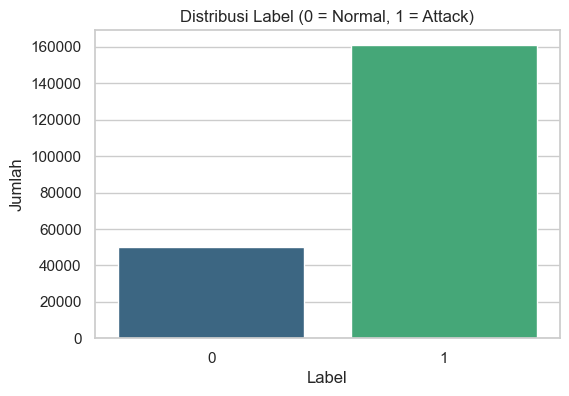

label
1    161043
0     50000
Name: count, dtype: int64

In [76]:
plt.figure(figsize=(6,4))
sns.countplot(x=df_clean["label"], palette="viridis")
plt.title("Distribusi Label (0 = Normal, 1 = Attack)")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

df_clean["label"].value_counts()


# Korelasi Fitur Numerik

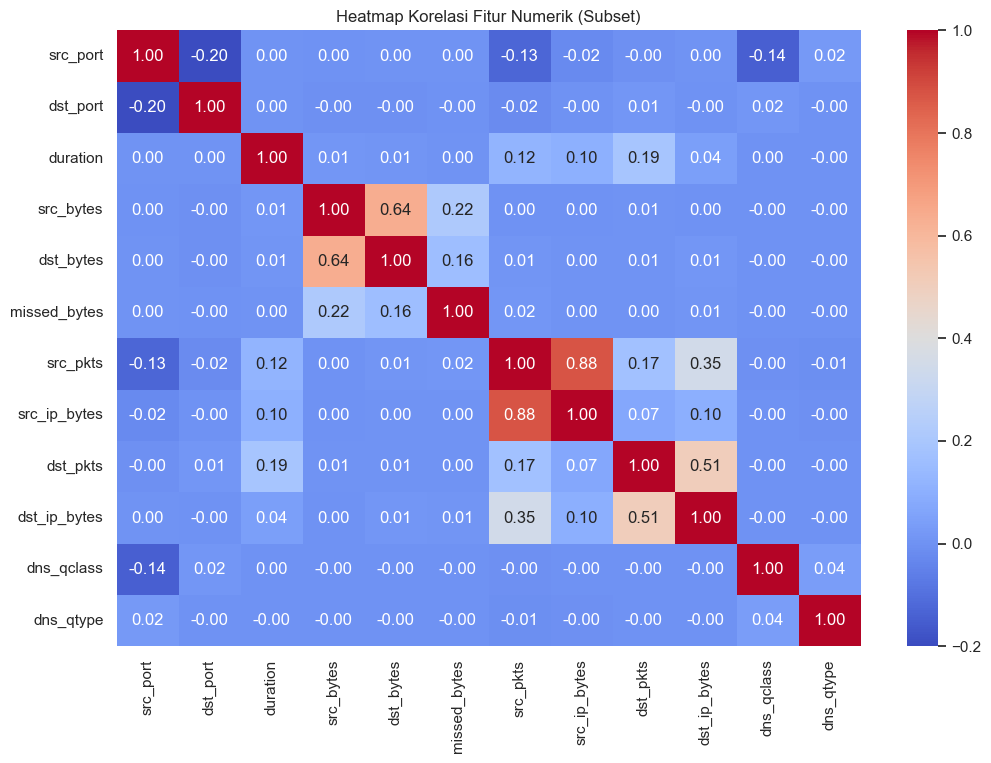

In [77]:
num_cols = df_clean.select_dtypes(include=["int64","float64"]).columns.tolist()
sample_cols = num_cols[:12] if len(num_cols) > 12 else num_cols

plt.figure(figsize=(12,8))
sns.heatmap(df_clean[sample_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Fitur Numerik (Subset)")
plt.show()


# Pisahkan Fitur & Target + OneHot Encoding

In [ ]:
target_col = "label"

# Pastikan kolom target ada
if target_col not in df_clean.columns:
    raise ValueError(f"Kolom target '{target_col}' tidak ditemukan!")

# Pisahkan fitur dan target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].astype(int)   # pastikan integer (0/1)

# Identifikasi kolom kategorikal (object atau category)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Kolom kategorikal:", cat_cols)

# Kolom numerik (sudah aman dari Cell 3)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nKolom numerik:", numeric_cols)

X.head()


Kolom kategorikal: ['proto', 'service', 'conn_state', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'http_trans_depth', 'http_method', 'http_version', 'weird_notice']

Kolom numerik: ['src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'http_request_body_len', 'http_response_body_len', 'http_status_code']


,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,ssl_cipher,ssl_resumed,ssl_established,http_trans_depth,http_method,http_version,http_request_body_len,http_response_body_len,http_status_code,weird_notice
0,4444,49178,tcp,none,290.371539,101568,2592,OTH,0,108,...,none,none,none,-,none,-,0,0,0,none
1,49180,8080,tcp,none,0.000102,0,0,REJ,0,1,...,none,none,none,-,none,-,0,0,0,none
2,49180,8080,tcp,none,0.000148,0,0,REJ,0,1,...,none,none,none,-,none,-,0,0,0,none
3,49180,8080,tcp,none,0.000113,0,0,REJ,0,1,...,none,none,none,-,none,-,0,0,0,none
4,49180,8080,tcp,none,0.000130,0,0,REJ,0,1,...,none,none,none,-,none,-,0,0,0,none


In [ ]:
# kategori fix (hindari salah deteksi)
categorical_cols = [
    "proto", "service", "conn_state", "http_method",
    "dns_AA", "dns_RD", "dns_RA", "dns_rejected",
    "ssl_version", "ssl_cipher", "ssl_resumed",
    "ssl_established", "weird_notice"
]

# kolom lain dianggap num, kecuali target
numeric_cols = [col for col in df_clean.columns 
                if col not in categorical_cols + ["label"]]

print("KATEGORIKAL FINAL:", categorical_cols)
print("NUMERIK FINAL:", numeric_cols)

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

for col in categorical_cols:
    df_clean[col] = df_clean[col].astype(str).replace("nan", "-").fillna("-")

print("SEMUA FIXED!")



KATEGORIKAL FINAL: ['proto', 'service', 'conn_state', 'http_method', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'weird_notice']
NUMERIK FINAL: ['src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'http_trans_depth', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code']
SEMUA FIXED!


In [ ]:
df_ready_clean = df_ready.copy()

for col in numeric_features_final:
    # ubah ke string dulu
    df_ready_clean[col] = df_ready_clean[col].astype(str)

    df_ready_clean[col] = (
        df_ready_clean[col]
        .str.replace("-", "0", regex=False)
        .str.replace(" ", "0", regex=False)
        .str.replace(",", ".", regex=False)
        .replace("nan", "0")
    )

    # convert ke float
    df_ready_clean[col] = pd.to_numeric(df_ready_clean[col], errors="coerce").fillna(0.0)

# cek hasil
df_ready_clean[numeric_features_final].head()
print("Kolom numerik 100% bersih & float!")

Kolom numerik 100% bersih & float!


In [81]:
X = df_ready_clean.drop(columns=["label"])
y = df_ready_clean["label"]


# Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Reset index supaya SMOTE tidak error
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

print("\nDistribusi y_train:")
print(y_train.value_counts())

print("\nDistribusi y_test:")
print(y_test.value_counts())



Train shape: (147730, 31)
Test shape : (63313, 31)

Distribusi y_train:
label
1    112730
0     35000
Name: count, dtype: int64

Distribusi y_test:
label
1    48313
0    15000
Name: count, dtype: int64


# Preprocessor (Scaling + OneHot)

In [ ]:
cat_cols_final = [c for c in cat_cols if c in X_train.columns]
numeric_cols_final = [c for c in numeric_cols if c in X_train.columns]

print("Final categorical cols:", cat_cols_final)
print("Final numeric cols:", numeric_cols_final)

# Preprocessor final
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_final),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_final)
    ],
    remainder="drop"   
)

print("Preprocessor siap ✔")


Final categorical cols: ['proto', 'service', 'conn_state', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'http_trans_depth', 'http_method', 'http_version', 'weird_notice']
Final numeric cols: ['src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'http_trans_depth', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code']
Preprocessor siap ✔


# Logistic Regression + SMOTE + Pipeline

In [ ]:
print("Training Logistic Regression...")

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_final),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features_final)
    ],
    remainder="drop"
)

logreg_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor_lr),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(
        max_iter=3000,
        solver="liblinear"
    ))
])

param_lr = {
    "model__C": [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_lr,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_

print("Logistic Regression selesai!")
print("Best Params:", grid_lr.best_params_)


Training Logistic Regression...
Logistic Regression selesai!
Best Params: {'model__C': 1}


# EVALUASI LOGISTIC REGRESSION + ROC-AUC + CONFUSION MATRIX


=== Logistic Regression ===
Accuracy : 0.9570546333296479
Precision: 0.9725942203242257
Recall   : 0.9710843872249705
F1 Score : 0.9718387173618088

ROC AUC  : 0.992461572109646

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     15000
           1       0.97      0.97      0.97     48313

    accuracy                           0.96     63313
   macro avg       0.94      0.94      0.94     63313
weighted avg       0.96      0.96      0.96     63313



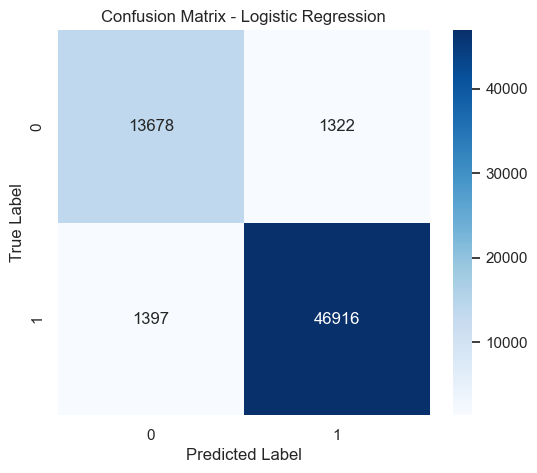

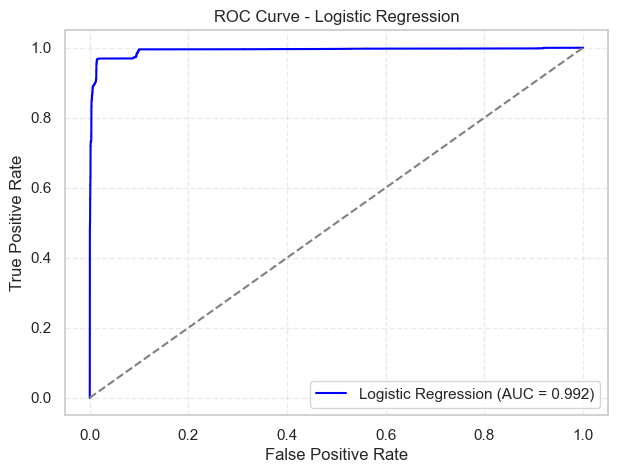

In [85]:
# Prediksi
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1 Score :", f1_score(y_test, y_pred_lr))
print("\nROC AUC  :", roc_auc_score(y_test, y_proba_lr))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))

# CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC CURVE

fpr, tpr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.3f})", color="blue")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [ ]:
for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    X_test[col]  = pd.to_numeric(X_test[col], errors='coerce').fillna(0)

print("Semua kolom numerik sudah dibersihkan dan dijamin float.")


Semua kolom numerik sudah dibersihkan dan dijamin float.


# Random Forest + SMOTE + Pipeline

In [ ]:
print("Training Random Forest...")

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features_final),
        ("num", StandardScaler(), numeric_features_final)
    ],
    remainder="drop"
)

rf_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced_subsample",
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)

print("Random Forest + SMOTE berhasil dilatih tanpa error!")


Training Random Forest...
Random Forest + SMOTE berhasil dilatih tanpa error!


In [88]:
# Jika kamu tidak punya encoder kategorikal, biarkan kosong:
encoders = {}

# Jika kamu tidak punya pengisi nilai kosong:
fill_values = {col: 0 for col in X_train.columns}

# Jika label kamu berupa 0 = normal, 1 = attack:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit([0, 1])


LabelEncoder()

# EVALUASI RANDOM FOREST + ROC-AUC + CONFUSION MATRIX


=== Random Forest ===
Accuracy : 0.9988943818804985
Precision: 0.9992342239791377
Recall   : 0.9993169540289363
F1 Score : 0.9992755872917314

ROC AUC  : 0.9999905636164179

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     48313

    accuracy                           1.00     63313
   macro avg       1.00      1.00      1.00     63313
weighted avg       1.00      1.00      1.00     63313



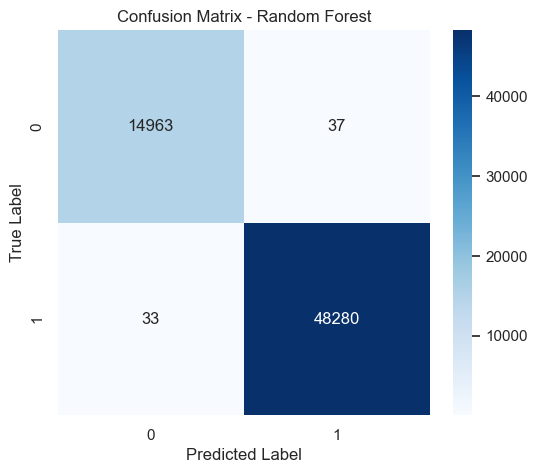

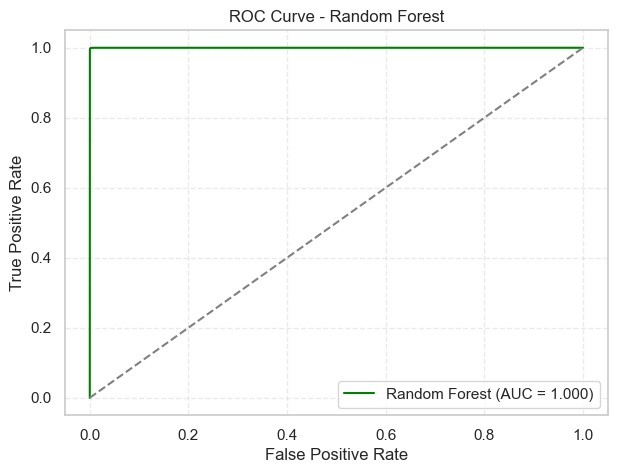

In [89]:
# Prediksi
y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))
print("\nROC AUC  :", roc_auc_score(y_test, y_proba_rf))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf))

# CONFUSION MATRIX

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC CURVE

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, 
         label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})",
         color="green")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [90]:
from sklearn.metrics import accuracy_score

# Prediksi ulang train & test
y_train_pred = rf_pipe.predict(X_train)
y_test_pred = rf_pipe.predict(X_test)

rf_train_accuracy = accuracy_score(y_train, y_train_pred)
rf_test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train accuracy:", rf_train_accuracy)
print("Test accuracy:", rf_test_accuracy)


Train accuracy: 1.0
Test accuracy: 0.9988943818804985


In [91]:
cat_cols = [col for col in cat_cols if col in X.columns]
numeric_cols = [col for col in numeric_cols if col in X.columns]

# Buat ulang preprocessor dengan kolom yang sudah difilter
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# FEATURE IMPORTANCE RANDOM FOREST 

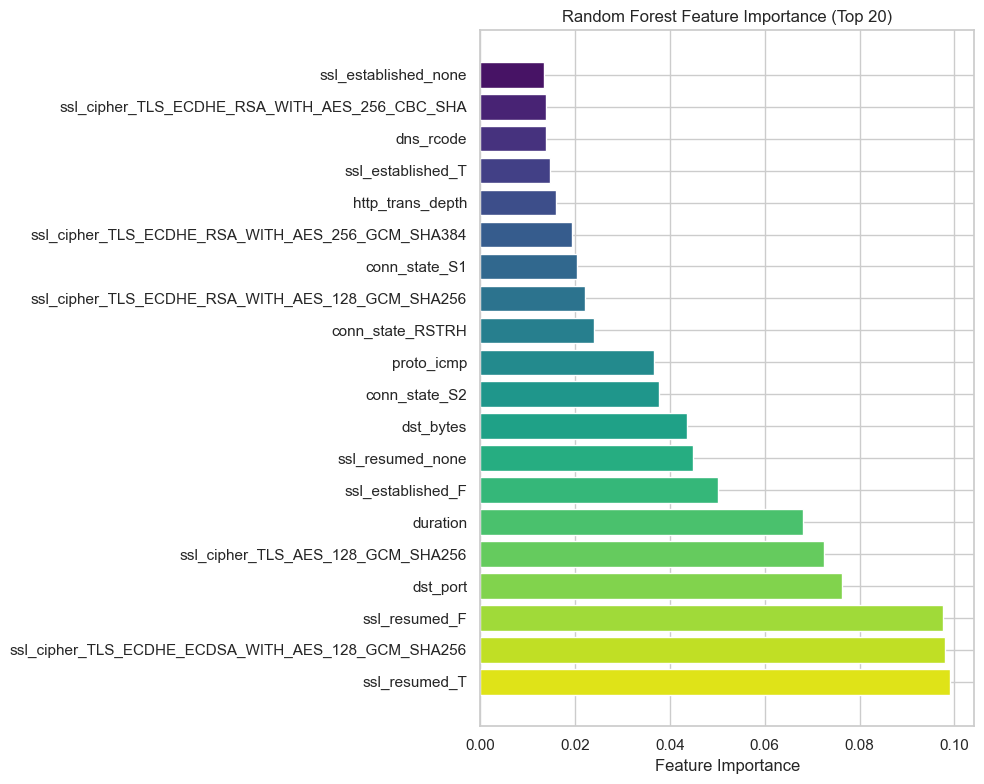

In [92]:
rf_raw = rf_pipe.named_steps["model"]
preprocessor.fit(X)
num_features = numeric_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = list(num_features) + list(cat_features)
importances = rf_raw.feature_importances_
idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.title("Random Forest Feature Importance (Top 20)")
plt.barh(range(len(idx)), importances[idx], 
         color=sns.color_palette("viridis", n_colors=len(idx)))
plt.yticks(range(len(idx)), [all_features[i] for i in idx])
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Perbandingan Model

In [93]:
hasil = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf)
    ]
})

hasil


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.957055,0.972594,0.971084,0.971839,0.992462
1,Random Forest,0.998894,0.999234,0.999317,0.999276,0.999991


# Simpan Kedua Model (.pkl)

In [ ]:
import joblib
import datetime

metadata = {
    "algorithm": "Random Forest",
    "created_at": str(datetime.datetime.now()),
    "train_accuracy": rf_pipe.score(X_train, y_train),
    "test_accuracy": rf_pipe.score(X_test, y_test)
}

# Simpan isi model
model_artifact = {
    "model": rf_pipe,
    "feature_names": X_train.columns.tolist(),
    "label_encoder": label_encoder,
    "encoders": {},                 
    "fill_values": fill_values,
    "metadata": metadata
}
joblib.dump(model_artifact, "random_forests_model.pkl")
print("Model disimpan sebagai random_forests_model.pkl")

Model disimpan sebagai random_forests_model.pkl
